In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121, MobileNetV2, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, GlobalAveragePooling2D, Dropout, Concatenate,
    LayerNormalization, MultiHeadAttention, Add, Flatten, Reshape, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.utils import shuffle

2025-05-29 08:11:26.510198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748506286.752293      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748506286.813634      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_dir  = '/kaggle/input/cards-image-datasetclassification/train'
test_dir  = '/kaggle/input/cards-image-datasetclassification/test'
val_dir  = '/kaggle/input/cards-image-datasetclassification/valid'

In [3]:
def load_images(base_dir):
    x_data, y_data = [], []
    for category in os.listdir(base_dir):
        category_path = os.path.join(base_dir, category)
        for img_file in os.listdir(category_path):
            img_path = os.path.join(category_path, img_file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (224,224))
            x_data.append(img)
            y_data.append(category)
    return np.array(x_data), np.array(y_data)

In [4]:
x_train, y_train = load_images(train_dir)
x_val, y_val = load_images(val_dir)
x_test, y_test = load_images(test_dir)

In [5]:
x_train, y_train = shuffle(x_train, y_train, random_state=42)
x_val, y_val = shuffle(x_val, y_val, random_state=42)
x_test, y_test = shuffle(x_test, y_test, random_state=42)

In [6]:
x_train, x_val, x_test = [x.astype('float32') / 255.0 for x in [x_train, x_val, x_test]]
categories = {label: idx for idx, label in enumerate(np.unique(y_train))}
y_train = np.array([categories[label] for label in y_train])
y_val = np.array([categories[label] for label in y_val])
y_test = np.array([categories[label] for label in y_test])

y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

num_classes = y_train_cat.shape[1]
input_shape = (224, 224, 3)

In [7]:
train_datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
                                   shear_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(x_train, y_train_cat, batch_size=32)
val_generator = val_datagen.flow(x_val, y_val_cat, batch_size=32)

In [ ]:
def build_hybrid_model(input_shape, num_classes, learning_rate):
    input_tensor = Input(shape=input_shape)

    # Base Models
    densenet = DenseNet121(include_top=False, weights='imagenet', input_tensor=input_tensor)
    inception = InceptionV3(include_top=False, weights='imagenet', input_tensor=input_tensor)
    mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_tensor)

    # Freeze bottom 80% of layers
    for base_model in [densenet, inception, mobilenet]:
        for layer in base_model.layers[:int(len(base_model.layers) * 0.8)]:
            layer.trainable = False
        for layer in base_model.layers[int(len(base_model.layers) * 0.8):]:
            layer.trainable = True

    # Extract Features
    densenet_out = GlobalAveragePooling2D()(densenet.output)
    inception_out = GlobalAveragePooling2D()(inception.output)
    mobilenet_out = GlobalAveragePooling2D()(mobilenet.output)

    # Concatenate Features
    merged = Concatenate()([densenet_out, inception_out, mobilenet_out])

    # Fully Connected Layers
    x = Dense(2048, activation='relu', kernel_regularizer=l2(0.001))(merged)
    x = Dropout(0.3)(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)

    # Build Model
    model = Model(inputs=input_tensor, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [9]:
def build_and_train_model(model_fn, model_name, learning_rate):
    print(f"\nTraining {model_name} with lr={learning_rate}...")

    if model_name.lower() == 'hybrid':
        model = build_hybrid_model(input_shape, num_classes, learning_rate)
    else:
        base_model = model_fn(include_top=False, weights='imagenet', input_shape=input_shape)
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
        x = Dropout(0.3)(x)
        x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
        x = Dropout(0.3)(x)
        output = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)
    
        model = Model(inputs=base_model.input, outputs=output)
    
        # Fine-tune last 20% layers
        for layer in base_model.layers[:-int(len(base_model.layers)*0.2)]:
            layer.trainable = False
    
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

    history = model.fit(train_generator, epochs=60, validation_data=val_generator,
                        callbacks=[early_stop, reduce_lr], verbose=1)

    # Evaluate
    loss, acc = model.evaluate(x_test, y_test_cat, verbose=0)
    print(f"\nTest Accuracy for {model_name}: {acc:.4f}")

    y_pred_probs = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    # 🧾 Classification Report
    target_names = list(categories.keys())
    print(f"\n📊 Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred_classes, target_names=target_names))

    # Confusion Matrix
    plt.figure(figsize=(10, 6))
    cm = confusion_matrix(y_test, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories.keys(), yticklabels=categories.keys())
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC Curve
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{model_name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

    # Accuracy & Loss Graph
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()



Training Hybrid with lr=0.0001...


I0000 00:00:1748506484.250798      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748506484.251478      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/tmp/ipykernel_35/762272160.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_tensor)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60


I0000 00:00:1748506557.845264      96 service.cc:148] XLA service 0x7e0fdc0030c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748506557.846666      96 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748506557.846691      96 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748506565.499796      96 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748506607.223507      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


239/239 ━━━━━━━━━━━━━━━━━━━━ 277s 678ms/step - accuracy: 0.0934 - loss: 8.2764 - val_accuracy: 0.3925 - val_loss: 6.0200 - learning_rate: 1.0000e-04
Epoch 2/60
239/239 ━━━━━━━━━━━━━━━━━━━━ 75s 314ms/step - accuracy: 0.3465 - loss: 6.2899 - val_accuracy: 0.6000 - val_loss: 5.0770 - learning_rate: 1.0000e-04
Epoch 3/60
239/239 ━━━━━━━━━━━━━━━━━━━━ 76s 317ms/step - accuracy: 0.5298 - loss: 5.3057 - val_accuracy: 0.6755 - val_loss: 4.5762 - learning_rate: 1.0000e-04
Epoch 4/60
239/239 ━━━━━━━━━━━━━━━━━━━━ 78s 324ms/step - accuracy: 0.6295 - loss: 4.6804 - val_accuracy: 0.7358 - val_loss: 4.0898 - learning_rate: 1.0000e-04
Epoch 5/60
239/239 ━━━━━━━━━━━━━━━━━━━━ 76s 316ms/step - accuracy: 0.7229 - loss: 4.1397 - val_accuracy: 0.7849 - val_loss: 3.7841 - learning_rate: 1.0000e-04
Epoch 6/60
239/239 ━━━━━━━━━━━━━━━━━━━━ 75s 311ms/step - accuracy: 0.7946 - loss: 3.7021 - val_accuracy: 0.8189 - val_loss: 3.5372 - learning_rate: 1.0000e-04
Epoch 7/60
239/239 ━━━━━━━━━━━━━━━━━━━━ 75s 311ms/step -

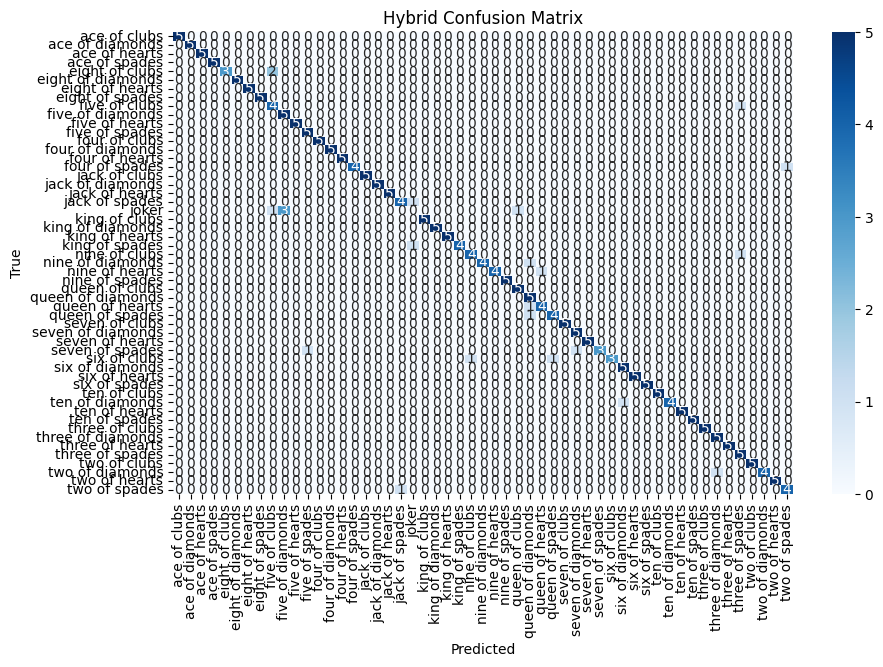

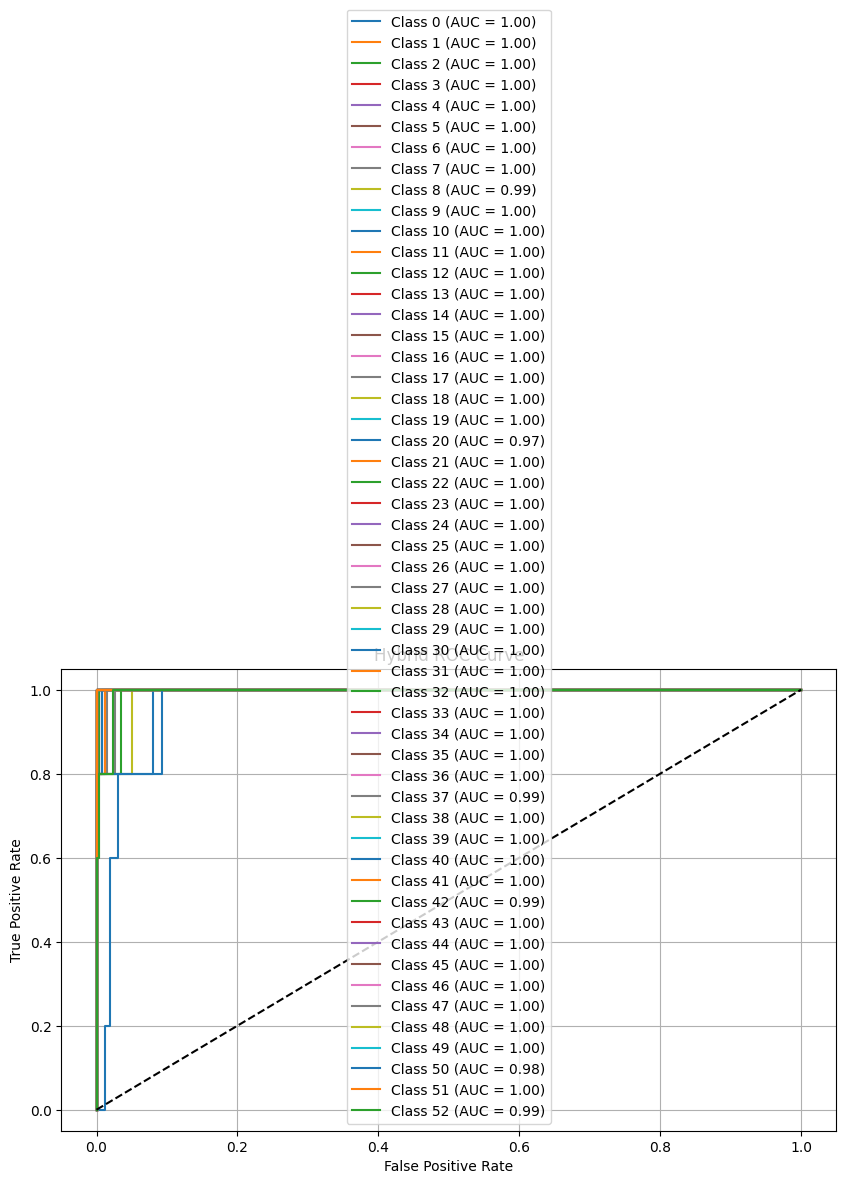

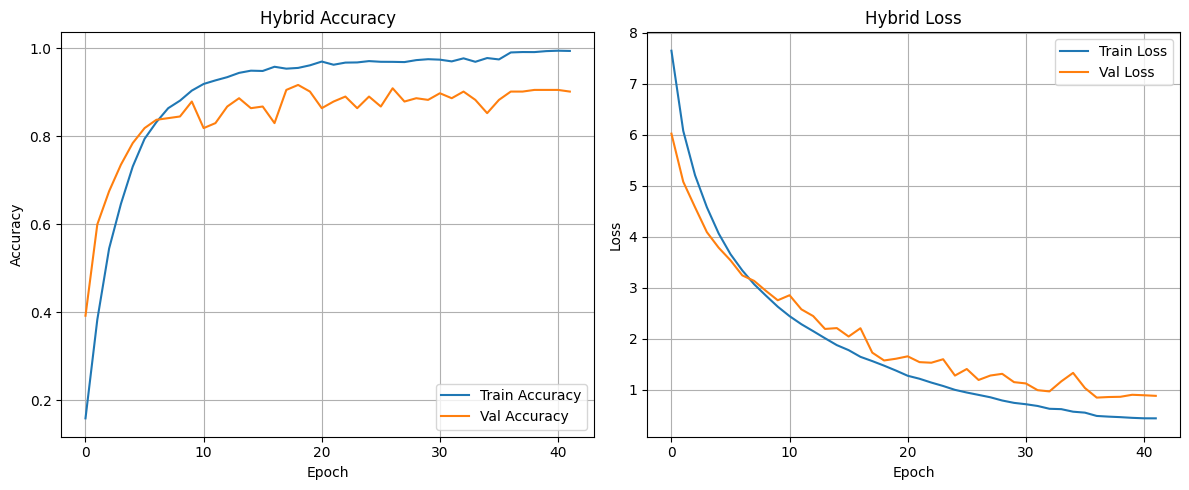

In [10]:
build_and_train_model(None, "Hybrid", learning_rate=1e-4)